## Things to try:
* Look at other notebooks for data preprocessing
* Look at other notebooks for data visualization
* Bet against odds ... %

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# loading CSV files downloaded from Kaggle
path = "data/"
df = pd.read_csv(path + "spreadspoke_scores.csv")
teams = pd.read_csv(path + "nfl_teams.csv")
games_elo = pd.read_csv(path + "nfl_elo.csv")

In [3]:
df.shape

(4750, 17)

In [4]:
df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,9/9/01,2001,1,False,Baltimore Ravens,17,6,Chicago Bears,BAL,-10.5,33.5,M&T Bank Stadium,False,72.0,6.0,79.0,NaN
1,9/9/01,2001,1,False,Buffalo Bills,6,24,New Orleans Saints,NO,-1.5,37.5,Ralph Wilson Stadium,False,80.0,12.0,58.0,NaN
2,9/9/01,2001,1,False,Cleveland Browns,6,9,Seattle Seahawks,SEA,-4.0,38.5,FirstEnergy Stadium,False,79.0,14.0,68.0,NaN
3,9/9/01,2001,1,False,Dallas Cowboys,6,10,Tampa Bay Buccaneers,TB,-9.0,34.0,Texas Stadium,False,75.0,13.0,78.0,NaN
4,9/9/01,2001,1,False,Green Bay Packers,28,6,Detroit Lions,GB,-5.5,41.5,Lambeau Field,False,61.0,7.0,93.0,NaN


In [5]:
teams.head()

,team_name,team_name_short,team_id,team_id_pfr,team_conference,team_division
0,Arizona Cardinals,Cardinals,ARI,CRD,NFC,NFC West
1,Atlanta Falcons,Falcons,ATL,ATL,NFC,NFC South
2,Baltimore Ravens,Ravens,BAL,RAV,AFC,AFC North
3,Buffalo Bills,Bills,BUF,BUF,AFC,AFC East
4,Carolina Panthers,Panthers,CAR,CAR,NFC,NFC South


In [6]:
games_elo.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,score1,score2
0,9/9/01,2001,0,NaN,TEN,MIA,1603.825,1568.090,0.641039,0.358961,1574.303,1597.611,23,31
1,9/9/01,2001,0,NaN,PHI,LAR,1546.139,1550.697,0.586116,0.413884,1529.430,1567.407,17,20
2,9/9/01,2001,0,NaN,BUF,NO,1521.265,1498.313,0.623937,0.376063,1482.992,1536.586,6,24
3,9/9/01,2001,0,NaN,CIN,NE,1380.427,1453.308,0.488660,0.511340,1400.399,1433.336,23,17
4,9/9/01,2001,0,NaN,CLE,SEA,1332.236,1461.802,0.408137,0.591863,1321.242,1472.795,6,9


## Combine data into one dataframe
**Note: use merge to join dataframe**
1. df - add team_id for home and away (data from teams)
2. df - add ELO prob for home and away 

In [7]:
df.team_home.describe()

count                     4750
unique                      32
top       New England Patriots
freq                       171
Name: team_home, dtype: object

In [8]:
df.team_away.describe()

count                 4750
unique                  32
top       Baltimore Ravens
freq                   156
Name: team_away, dtype: object

In [9]:
df.team_favorite_id.describe()

count     4750
unique      32
top         NE
freq       263
Name: team_favorite_id, dtype: object

In [10]:
# mapping team_id to the correct teams
df['team_home'] = df.team_home.map(teams.set_index('team_name')['team_id'].to_dict())
df['team_away'] = df.team_away.map(teams.set_index('team_name')['team_id'].to_dict())

In [11]:
# Get division info. in each team to create 'division_game' flag

In [12]:
new_df = pd.merge(df, teams[["team_id", "team_division"]], how='inner', left_on=['team_home'], right_on=['team_id'])
new_df = pd.merge(new_df, teams[["team_id", "team_division"]], how='inner', left_on=['team_away'], right_on=['team_id'])
new_df = new_df.rename(columns={'team_division_x': 'team_home_division', 'team_division_y': 'team_away_division'})

# drop unused columns
new_df = new_df.drop(['team_id_x', 'team_id_y'], axis=1)

new_df["division_game"] = new_df["team_home_division"] == new_df["team_away_division"]

In [13]:
new_df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,team_home_division,team_away_division,division_game
0,9/9/01,2001,1,False,BAL,17,6,CHI,BAL,-10.5,33.5,M&T Bank Stadium,False,72.0,6.0,79.0,NaN,AFC North,NFC North,False
1,12/20/09,2009,15,False,BAL,31,7,CHI,BAL,-11.0,39.0,M&T Bank Stadium,False,30.0,12.0,68.0,NaN,AFC North,NFC North,False
2,10/15/17,2017,6,False,BAL,24,27,CHI,BAL,-6.5,38.5,M&T Bank Stadium,False,73.0,10.0,NaN,NaN,AFC North,NFC North,False
3,9/29/02,2002,4,False,BUF,33,27,CHI,BUF,-3.0,46.5,Ralph Wilson Stadium,False,57.0,9.0,76.0,NaN,AFC East,NFC North,False
4,11/7/10,2010,9,False,BUF,19,22,CHI,CHI,-3.0,41.5,Rogers Centre,True,72.0,0.0,NaN,DOME,AFC East,NFC North,False


In [14]:
new_df.division_game.describe()

count      4750
unique        2
top       False
freq       3042
Name: division_game, dtype: object

### Merge elo data

In [27]:
new_df = pd.merge(df, teams[["team_id", "team_division"]], how='inner', left_on=['team_home'], right_on=['team_id'])
new_df = pd.merge(new_df, teams[["team_id", "team_division"]], how='inner', left_on=['team_away'], right_on=['team_id'])
new_df = new_df.rename(columns={'team_division_x': 'team_home_division', 'team_division_y': 'team_away_division'})

# drop unused columns
new_df = new_df.drop(['team_id_x', 'team_id_y'], axis=1)

new_df["division_game"] = new_df["team_home_division"] == new_df["team_away_division"]

# change data type of date columns
new_df['schedule_date'] = pd.to_datetime(new_df['schedule_date'])
games_elo['date'] = pd.to_datetime(games_elo['date'])

In [28]:
new_df = new_df.merge(games_elo[['date', 'team1', 'team2', 'elo_prob1', 'elo_prob2']], left_on=['schedule_date', 'team_home', 'team_away'], right_on=['date', 'team1', 'team2'], how='left')

In [29]:
new_df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,weather_humidity,weather_detail,team_home_division,team_away_division,division_game,date,team1,team2,elo_prob1,elo_prob2
0,2001-09-09,2001,1,False,BAL,17,6,CHI,BAL,-10.5,...,79.0,NaN,AFC North,NFC North,False,2001-09-09,BAL,CHI,0.847023,0.152977
1,2009-12-20,2009,15,False,BAL,31,7,CHI,BAL,-11.0,...,68.0,NaN,AFC North,NFC North,False,2009-12-20,BAL,CHI,0.781479,0.218521
2,2017-10-15,2017,6,False,BAL,24,27,CHI,BAL,-6.5,...,NaN,NaN,AFC North,NFC North,False,2017-10-15,BAL,CHI,0.751455,0.248545
3,2002-09-29,2002,4,False,BUF,33,27,CHI,BUF,-3.0,...,76.0,NaN,AFC East,NFC North,False,2002-09-29,BUF,CHI,0.401823,0.598177
4,2010-11-07,2010,9,False,BUF,19,22,CHI,CHI,-3.0,...,NaN,DOME,AFC East,NFC North,False,2010-11-07,BUF,CHI,0.421488,0.578512


In [30]:
# merge to fix neutral games where team_home and team_away are switched
games_elo2 = games_elo.rename(columns={'team1' : 'team2', 
                                       'team2' : 'team1', 
                                       'elo1' : 'elo2', 
                                       'elo2' : 'elo1',
                                       'elo_prob1' : 'elo_prob2', 
                                       'elo_prob2' : 'elo_prob1'})
# games_elo2 = games_elo.rename(columns={'team1' : 'team2', 'team2' : 'team1', 'elo1' : 'elo2', 'elo2' : 'elo1'})

In [31]:
# new_df = new_df.merge(games_elo, left_on=['schedule_date', 'team_home', 'team_away'], right_on=['date', 'team1', 'team2'], how='left')
# new_df = new_df.merge(games_elo2, left_on=['schedule_date', 'team_home', 'team_away'], right_on=['date', 'team1', 'team2'], how='left')
new_df = new_df.merge(games_elo2[['date', 'team1', 'team2', 'elo_prob1', 'elo_prob2']], left_on=['schedule_date', 'team_home', 'team_away'], right_on=['date', 'team1', 'team2'], how='left')
new_df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,date_x,team1_x,team2_x,elo_prob1_x,elo_prob2_x,date_y,team1_y,team2_y,elo_prob1_y,elo_prob2_y
0,2001-09-09,2001,1,False,BAL,17,6,CHI,BAL,-10.5,...,2001-09-09,BAL,CHI,0.847023,0.152977,NaT,NaN,NaN,NaN,NaN
1,2009-12-20,2009,15,False,BAL,31,7,CHI,BAL,-11.0,...,2009-12-20,BAL,CHI,0.781479,0.218521,NaT,NaN,NaN,NaN,NaN
2,2017-10-15,2017,6,False,BAL,24,27,CHI,BAL,-6.5,...,2017-10-15,BAL,CHI,0.751455,0.248545,NaT,NaN,NaN,NaN,NaN
3,2002-09-29,2002,4,False,BUF,33,27,CHI,BUF,-3.0,...,2002-09-29,BUF,CHI,0.401823,0.598177,NaT,NaN,NaN,NaN,NaN
4,2010-11-07,2010,9,False,BUF,19,22,CHI,CHI,-3.0,...,2010-11-07,BUF,CHI,0.421488,0.578512,NaT,NaN,NaN,NaN,NaN


In [32]:
new_df.columns.values

array(['schedule_date', 'schedule_season', 'schedule_week',
       'schedule_playoff', 'team_home', 'score_home', 'score_away',
       'team_away', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'stadium', 'stadium_neutral',
       'weather_temperature', 'weather_wind_mph', 'weather_humidity',
       'weather_detail', 'team_home_division', 'team_away_division',
       'division_game', 'date_x', 'team1_x', 'team2_x', 'elo_prob1_x',
       'elo_prob2_x', 'date_y', 'team1_y', 'team2_y', 'elo_prob1_y',
       'elo_prob2_y'], dtype=object)

In [22]:
# new_df[new_df["elo_prob1"].isnull()]

In [34]:
# separating merged columns into x and y cols
x_cols = ['date_x', 'team1_x', 'team2_x', 'elo_prob1_x', 'elo_prob2_x']
y_cols = ['date_y', 'team1_y', 'team2_y', 'elo_prob1_y','elo_prob2_y']

# filling null values for games_elo merged cols
for x, y in zip(x_cols, y_cols):
    new_df[x] = new_df[x].fillna(new_df[y]) 

# removing y_cols from dataframe    
new_df = new_df[['schedule_date', 'schedule_season', 'schedule_week',
       'schedule_playoff', 'team_home', 'score_home', 'score_away',
       'team_away', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'stadium', 'stadium_neutral',
       'weather_temperature', 'weather_wind_mph', 'weather_humidity',
       'weather_detail', 'team_home_division', 'team_away_division',
       'division_game', 'date_x', 'team1_x', 'team2_x', 'elo_prob1_x',
       'elo_prob2_x']]

# remove _x ending from column names
new_df.columns = new_df.columns.str.replace('_x', '')

In [42]:
new_df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,weather_humidity,weather_detail,team_home_division,team_away_division,division_game,date,team1,team2,elo_prob1,elo_prob2
0,2001-09-09,2001,1,False,BAL,17,6,CHI,BAL,-10.5,...,79.0,NaN,AFC North,NFC North,False,2001-09-09,BAL,CHI,0.847023,0.152977
1,2009-12-20,2009,15,False,BAL,31,7,CHI,BAL,-11.0,...,68.0,NaN,AFC North,NFC North,False,2009-12-20,BAL,CHI,0.781479,0.218521
2,2017-10-15,2017,6,False,BAL,24,27,CHI,BAL,-6.5,...,NaN,NaN,AFC North,NFC North,False,2017-10-15,BAL,CHI,0.751455,0.248545
3,2002-09-29,2002,4,False,BUF,33,27,CHI,BUF,-3.0,...,76.0,NaN,AFC East,NFC North,False,2002-09-29,BUF,CHI,0.401823,0.598177
4,2010-11-07,2010,9,False,BUF,19,22,CHI,CHI,-3.0,...,NaN,DOME,AFC East,NFC North,False,2010-11-07,BUF,CHI,0.421488,0.578512


In [38]:
new_df.elo_prob1.describe()

count    4460.000000
mean        0.583040
std         0.170068
min         0.092782
25%         0.465182
50%         0.593258
75%         0.711751
max         0.964578
Name: elo_prob1, dtype: float64

In [39]:
# Drop column where there are eno Elo information
new_df = new_df.dropna(subset=['elo_prob1', 'elo_prob2'])

In [45]:
# creating result column df.loc[(df.score_home > df.score_away), 'result'
new_df['result'] = (new_df.score_home > new_df.score_away).astype(int)

/Users/ukritw/miniconda3/envs/machine_learning/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [46]:
new_df.shape

(4460, 26)

In [48]:
new_df.tail()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,weather_detail,team_home_division,team_away_division,division_game,date,team1,team2,elo_prob1,elo_prob2,result
4745,2002-12-15,2002,15,False,HOU,19,23,BAL,BAL,-3.0,...,DOME,AFC South,AFC North,False,2002-12-15,HOU,BAL,0.345583,0.654417,0
4746,2008-11-09,2008,10,False,HOU,13,41,BAL,HOU,-2.5,...,DOME,AFC South,AFC North,False,2008-11-09,HOU,BAL,0.501187,0.498813,0
4747,2010-12-13,2010,14,False,HOU,28,34,BAL,BAL,-3.0,...,DOME,AFC South,AFC North,False,2010-12-13,HOU,BAL,0.409726,0.590274,0
4748,2012-10-21,2012,7,False,HOU,43,13,BAL,HOU,-6.5,...,DOME (Open Roof),AFC South,AFC North,False,2012-10-21,HOU,BAL,0.529222,0.470778,1
4749,2014-12-21,2014,16,False,HOU,25,13,BAL,BAL,-6.0,...,DOME (Open Roof),AFC South,AFC North,False,2014-12-21,HOU,BAL,0.386010,0.613990,1


## Exploratory Data Analysis

In [3]:
df.describe()

,schedule_season,score_home,score_away,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,weather_humidity
count,4750.000000,4750.00000,4750.000000,4750.000000,4750.000000,4639.000000,4639.000000,2407.000000
mean,2009.507158,23.25200,20.688000,-5.415263,43.241368,60.584178,6.271826,64.844620
std,5.170768,10.38058,10.043385,3.366694,4.904403,15.585365,5.437921,16.712769
min,2001.000000,0.00000,0.000000,-26.500000,30.000000,-6.000000,0.000000,4.000000
25%,2005.000000,16.00000,13.000000,-7.000000,40.000000,50.000000,0.000000,54.000000
50%,2010.000000,23.00000,20.000000,-4.500000,43.500000,65.000000,6.000000,66.000000
75%,2014.000000,30.00000,27.000000,-3.000000,46.500000,72.000000,10.000000,77.000000
max,2018.000000,62.00000,59.000000,-1.000000,63.500000,97.000000,40.000000,100.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11172c5f8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e609a20>]], dtype=object)

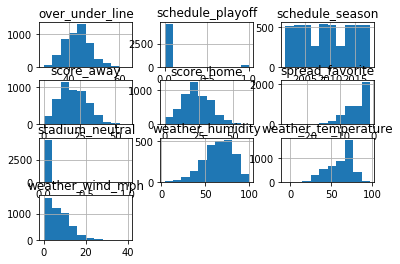

In [13]:
df.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e69f320>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11f742828>]], dtype=object)

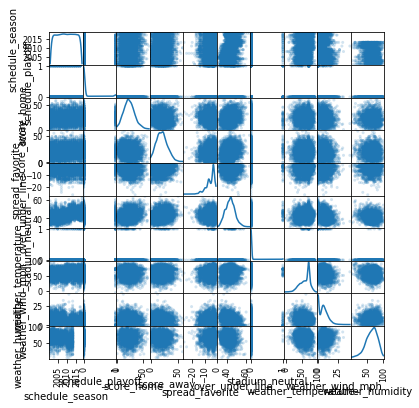

In [14]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde')